## 数据挖掘互评作业二: 频繁模式与关联规则挖掘
    姓名：刘文楷
    学号：1120183560
    仓库地址：https://github.com/KevinLiu76/BIT_DM_Homework/tree/main/homework2

### 一. 预处理
选择数据集：Wine Reviews

In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

读取数据并展示前五行

In [21]:
data = pd.read_csv("wine-data/winemag-data_first150k.csv")
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


样本数据相关信息

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


数据集中第一个属性未命名，是评论的序号，是唯一的，description属性是对于葡萄酒的自然语言描述，也是唯一值，二者在分析过程中不做考虑。

country、province、region_1和region_2是对葡萄酒产地的位置信息，出于分析复杂性和这四个属性的数据缺失情况考虑，这四个属性中只选择country进行挖掘。country属性中存在3个缺失值，所以需要通过属性的相关关系来填补缺失值，使用designation的属性来判断所属国家。

根据空值的分布，定义一个从designation到country的转换字典

In [23]:
designation2country = {
    "Askitikos":"Greece",    
    "Shah":"US",
    "Piedra Feliz":"Chile",
}
#处理country的空值
def country_nan_hander(data):
    for i in range(0,len(data)):
        tmp = data.iloc[i,1]
        if pd.isnull(tmp):
            designation = data.iloc[i,3]
            data.iloc[i,1] = designation2country[designation]
    return data

对于price和points这样的数值属性，对price进行离散化处理，此外points和price属性需要加上前缀，方便区分频繁项生成结果。

In [24]:
def points_discretization(value):
    return "points-"+str(int(value/5))

def price_discretization(value):
    if value < 100:
        return "price-"+str(int(value/10))
    else:
        return "price-10"

初步分析过程中选取的属性包括designation、country、price、points，在之后的找出频繁模式调用mlxtend库来实现，因此还需要将数据处理成相应的格式。

In [25]:
#处理country的空值
country_nan_hander(data)

#过滤属性
data = data.drop(['Unnamed: 0','description','province','region_1','region_2','variety','winery','designation'],axis = 1)

In [26]:
#离散化处理
data.loc[:,'points'] = data['points'].map(lambda x:points_discretization(x))
data.loc[:,'price'] = data['price'].map(lambda x:price_discretization(x))

In [27]:
#dataframe转换为列表
def deal(data):
    return data.to_list()
data_arr = data.apply(deal,axis=1).tolist()

In [28]:
#TransactionEncoder转换
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
tf = te.fit_transform(data_arr)
new_df = pd.DataFrame(tf,columns=te.columns_)

### 二. 频繁模式

In [29]:
from mlxtend.frequent_patterns import apriori
result = apriori(new_df, min_support=0.03, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)

In [30]:
print(result.shape)
result[:20]

(52, 2)


,support,itemsets
9,0.526887,(points-17)
7,0.413423,(US)
12,0.303419,(price-1)
10,0.299669,(points-18)
14,0.212986,(price-2)
37,0.201034,"(price-1, points-17)"
29,0.199788,"(US, points-17)"
4,0.155556,(Italy)
8,0.153694,(points-16)
3,0.139787,(France)


### 三. 关联规则

从频繁项集中导出关联规则，并计算其支持度和置信度。这里使用mlxtend包中的association_rules方法，支持度阈值为0.03，置信度阈值设为0.4，方法默认状态下会计算关联规则的计算支持度、置信度和提升度。

In [31]:
from mlxtend.frequent_patterns import association_rules
rules =  association_rules(result,metric ='confidence',min_threshold = 0.4)
rules = rules.drop(['leverage','conviction'],axis = 1)
print(rules.shape)
rules

(28, 7)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(price-1),(points-17),0.303419,0.526887,0.201034,0.662561,1.257503
1,(US),(points-17),0.413423,0.526887,0.199788,0.483253,0.917185
2,(price-2),(points-17),0.212986,0.526887,0.131604,0.617900,1.172737
3,(points-18),(US),0.299669,0.413423,0.128748,0.429636,1.039215
4,(price-2),(US),0.212986,0.413423,0.106460,0.499844,1.209038
5,(Italy),(points-17),0.155556,0.526887,0.093964,0.604055,1.146461
6,(points-16),(price-1),0.153694,0.303419,0.079454,0.516963,1.703795
7,(price-3),(US),0.124554,0.413423,0.076784,0.616469,1.491132
8,(points-16),(US),0.153694,0.413423,0.076048,0.494805,1.196849
9,(France),(points-17),0.139787,0.526887,0.066998,0.479287,0.909659


导出各项关联规则

In [32]:
for index, row in rules.iterrows():
    #print(row)
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    print("%s ⇒ %s (suupport = %f, confidence = %f )"%(t1,t2,row['support'],row['confidence']))

('price-1',) ⇒ ('points-17',) (suupport = 0.201034, confidence = 0.662561 )
('US',) ⇒ ('points-17',) (suupport = 0.199788, confidence = 0.483253 )
('price-2',) ⇒ ('points-17',) (suupport = 0.131604, confidence = 0.617900 )
('points-18',) ⇒ ('US',) (suupport = 0.128748, confidence = 0.429636 )
('price-2',) ⇒ ('US',) (suupport = 0.106460, confidence = 0.499844 )
('Italy',) ⇒ ('points-17',) (suupport = 0.093964, confidence = 0.604055 )
('points-16',) ⇒ ('price-1',) (suupport = 0.079454, confidence = 0.516963 )
('price-3',) ⇒ ('US',) (suupport = 0.076784, confidence = 0.616469 )
('points-16',) ⇒ ('US',) (suupport = 0.076048, confidence = 0.494805 )
('France',) ⇒ ('points-17',) (suupport = 0.066998, confidence = 0.479287 )
('price-3',) ⇒ ('points-17',) (suupport = 0.062327, confidence = 0.500399 )
('US', 'price-2') ⇒ ('points-17',) (suupport = 0.060757, confidence = 0.570700 )
('price-2', 'points-17') ⇒ ('US',) (suupport = 0.060757, confidence = 0.461662 )
('US', 'price-1') ⇒ ('points-17',)

### 四. 规则评价

这里使用提升度Lift和全置信度allconf。提升度Lift已经在 4.导出关联规则 的过程中被计算出来了，如下计算全置信度。

In [33]:
def allconf(x):
    return x.support/max(x['antecedent support'],x['consequent support'])
allconf_list = []
for index, row in rules.iterrows():
    allconf_list.append(allconf(row))
rules['allconf'] = allconf_list
rules.drop(['antecedent support','consequent support'],axis=1,inplace=False)#.sort_values(by=['lift'], ascending=False)

,antecedents,consequents,support,confidence,lift,allconf
0,(price-1),(points-17),0.201034,0.662561,1.257503,0.381550
1,(US),(points-17),0.199788,0.483253,0.917185,0.379186
2,(price-2),(points-17),0.131604,0.617900,1.172737,0.249777
3,(points-18),(US),0.128748,0.429636,1.039215,0.311420
4,(price-2),(US),0.106460,0.499844,1.209038,0.257508
5,(Italy),(points-17),0.093964,0.604055,1.146461,0.178338
6,(points-16),(price-1),0.079454,0.516963,1.703795,0.261863
7,(price-3),(US),0.076784,0.616469,1.491132,0.185727
8,(points-16),(US),0.076048,0.494805,1.196849,0.183948
9,(France),(points-17),0.066998,0.479287,0.909659,0.127158


过滤allconf小于0.1的规则，按照lift从大到小排序取前16项，得到用于分析的关联规则。

In [34]:
final_rules = rules.iloc[:]
from sklearn.preprocessing import LabelEncoder
for index, row in final_rules.iterrows():
    #print(row)
    if row['allconf'] < 0.1:
        final_rules.drop(index=index,inplace=True) 
final_rules = final_rules.sort_values(by=['lift'], ascending=False)[:16]
final_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,allconf
16,(price-10),(France),0.118121,0.139787,0.049930,0.422706,3.023936,0.357190
27,(price-5),(points-18),0.049990,0.299669,0.030405,0.608217,2.029632,0.101461
19,(price-4),(points-18),0.082840,0.299669,0.043855,0.529393,1.766594,0.146344
6,(points-16),(price-1),0.153694,0.303419,0.079454,0.516963,1.703795,0.261863
7,(price-3),(US),0.124554,0.413423,0.076784,0.616469,1.491132,0.185727
22,"(US, points-16)",(price-1),0.076048,0.303419,0.033936,0.446245,1.470723,0.111846
14,(price-10),(points-18),0.118121,0.299669,0.051898,0.439365,1.466169,0.173185
17,(price-4),(US),0.082840,0.413423,0.049692,0.599856,1.450948,0.120196
15,(price-3),(points-18),0.124554,0.299669,0.049990,0.401351,1.339316,0.166818
0,(price-1),(points-17),0.303419,0.526887,0.201034,0.662561,1.257503,0.381550


### 五. 结果展示

In [35]:
i = 1
for index, row in final_rules.iterrows():
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    print("%d : %s ⇒ %s (suupport = %f, confidence = %f )"%(i,t1,t2,row['support'],row['confidence']))
    i = i + 1

1 : ('price-10',) ⇒ ('France',) (suupport = 0.049930, confidence = 0.422706 )
2 : ('price-5',) ⇒ ('points-18',) (suupport = 0.030405, confidence = 0.608217 )
3 : ('price-4',) ⇒ ('points-18',) (suupport = 0.043855, confidence = 0.529393 )
4 : ('points-16',) ⇒ ('price-1',) (suupport = 0.079454, confidence = 0.516963 )
5 : ('price-3',) ⇒ ('US',) (suupport = 0.076784, confidence = 0.616469 )
6 : ('US', 'points-16') ⇒ ('price-1',) (suupport = 0.033936, confidence = 0.446245 )
7 : ('price-10',) ⇒ ('points-18',) (suupport = 0.051898, confidence = 0.439365 )
8 : ('price-4',) ⇒ ('US',) (suupport = 0.049692, confidence = 0.599856 )
9 : ('price-3',) ⇒ ('points-18',) (suupport = 0.049990, confidence = 0.401351 )
10 : ('price-1',) ⇒ ('points-17',) (suupport = 0.201034, confidence = 0.662561 )
11 : ('price-2',) ⇒ ('US',) (suupport = 0.106460, confidence = 0.499844 )
12 : ('points-16',) ⇒ ('US',) (suupport = 0.076048, confidence = 0.494805 )
13 : ('price-2',) ⇒ ('points-17',) (suupport = 0.131604, co

可视化

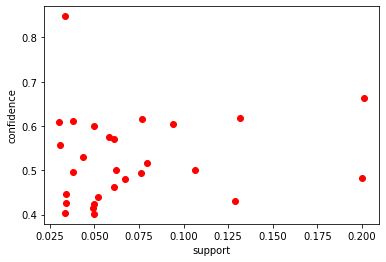

In [36]:
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.confidence[i],c='r')

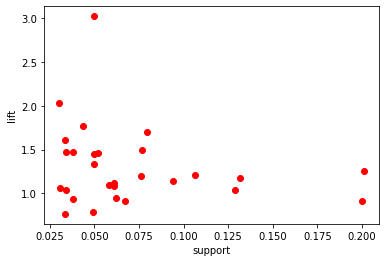

In [37]:
plt.xlabel('support')
plt.ylabel('lift')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.lift[i],c='r')